In [1]:
"""
a script to download, filter, preprocess, and partition the raw data into training and test splits
"""



'\na script to download, filter, preprocess, and partition the raw data into training and test splits\n'

In [1]:
!pip install simpleITK

     ---------------------------------------- 0.0/27.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/27.0 MB ? eta -:--:--
     --------------------------------------- 0.0/27.0 MB 326.8 kB/s eta 0:01:23
     --------------------------------------- 0.1/27.0 MB 491.5 kB/s eta 0:00:55
     --- ------------------------------------ 2.2/27.0 MB 11.7 MB/s eta 0:00:03
     ----------- ---------------------------- 7.7/27.0 MB 32.7 MB/s eta 0:00:01
     ------------------ ------------------- 13.2/27.0 MB 108.8 MB/s eta 0:00:01
     -------------------------- ----------- 18.5/27.0 MB 108.8 MB/s eta 0:00:01
     --------------------------- ---------- 19.9/27.0 MB 108.8 MB/s eta 0:00:01
     ----------------------------- --------- 20.2/27.0 MB 59.5 MB/s eta 0:00:01
     ----------------------------------- --- 24.7/27.0 MB 59.5 MB/s eta 0:00:01
     --------------------------------------  27.0/27.0 MB 59.5 MB/s eta 0:00:01
     --------------------------------------  27.0/27.0 M

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import json
import os
import scipy

In [8]:
def read_image(ct_path):
    if os.path.exists(ct_path):
        itkimage = sitk.ReadImage(ct_path)
        ct_scan = sitk.GetArrayFromImage(itkimage)
        origin = np.array(list(reversed(itkimage.GetOrigin())))
        spacing = np.array(list(reversed(itkimage.GetSpacing())))
        direction = np.array(list(reversed(itkimage.GetDirection())))
        return ct_scan, origin, spacing, direction
    else:
        print("The file path doesn't exist")
ct_path = r"\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\3\TRV1P3CTI.nii"
ct_scan, origin, spacing, direction = read_image(ct_path)
print(ct_scan.shape)
print(origin)
print(spacing)
print(direction.reshape(3,3))

(56, 512, 512)
[0. 0. 0.]
[2.5        0.48828101 0.48828101]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


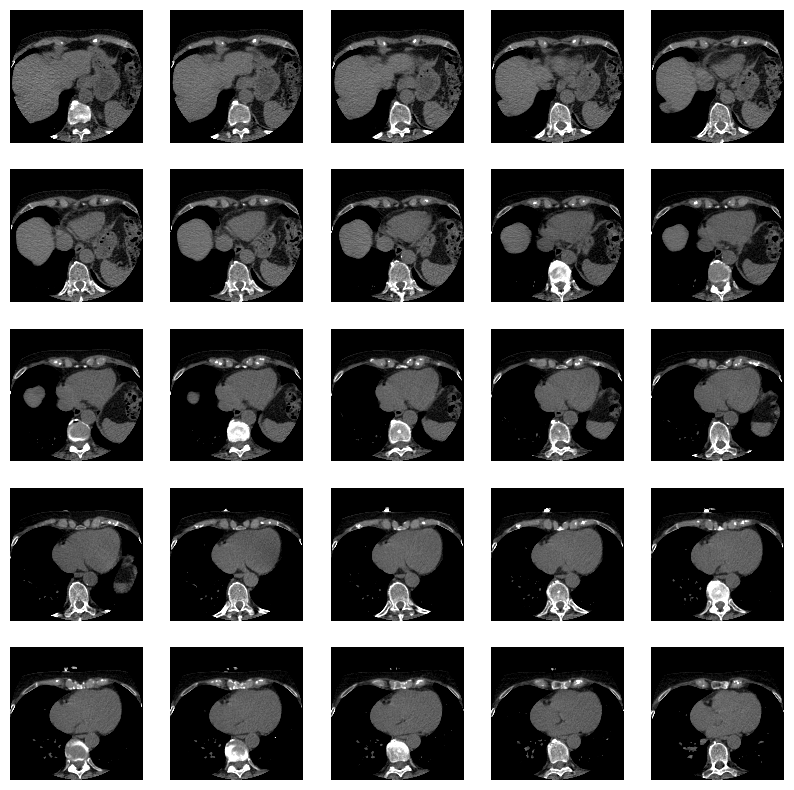

In [9]:
def plot_scan(ct_scan, n=5, window=500, level=100):
    #visualizing the first n*n images of the given patient data
    fig, ax = plt.subplots(n, n, figsize=(10, 10))
    assert n*n < ct_scan.shape[0], "n out of range. Please enter smaller number"
    for i in range(n*n):
        row = i // n
        col = i % n
        vmin = level - window/2
        vmax = level + window/2
        ax[row,col].imshow(ct_scan[i], cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        ax[row,col].axis('off')
    plt.show()

plot_scan(ct_scan)

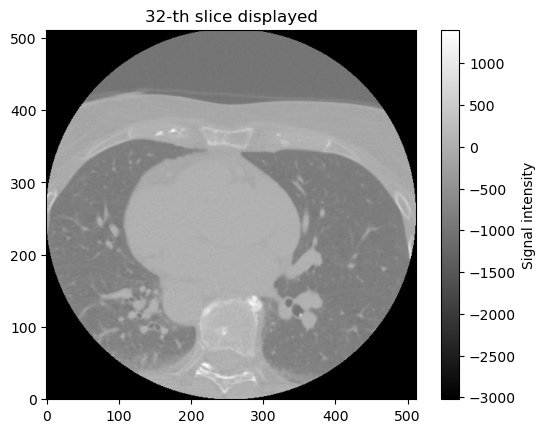

In [11]:
def plot_single_slice(ct_scan, n=32):
  """
  plots n-th slice of a scan
  """
  plt.imshow(np.rot90(ct_scan[n], k=2), cmap=plt.cm.gray, origin="lower")
  plt.title(f'{n}-th slice displayed')
  plt.colorbar(label='Signal intensity')
  plt.show()  

plot_single_slice(ct_scan)

In [18]:
#get 3D bounding box coordinates from json file
def read_from_json(json_path):
    if os.path.exists(json_path):
        with open(label_path) as f:
            label_json = json.load(f)
            x, y, z = label_json['markups'][0]['center']
            length, width, height = label_json['markups'][0]['size']
            orientation = np.array(label_json['markups'][0]['orientation'])
            center, dimension = [x,y,z], [length, width, height]
            return center, dimension
    else:
        print(f"The file '{json_path}' does not exist.")

label_path = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\3\bifurcation.json'
center, dimension = read_from_json(label_path)
print(center, dimension)

[146.74349975585938, 135.17697143554688, 99.39756774902344] [7.4595013353900015, 7.346364512383218, 9.047961255810506]


In [37]:
def get_3Dbox_coordinates(json_path, spacing=None, scaling_factor=None):
    center, dimension = read_from_json(json_path)
    if spacing is not None:
        x_center = center[0] / spacing[1]
        y_center = center[1] / spacing[2]
        z_center = center[2] / spacing[0]
        center= [x_center, y_center, z_center]
    if scaling_factor is not None: 
        dimension = dimension * scaling_factor
    return center, dimension


In [15]:
def generate_yolo_labels(ct_scan, center_coordinates, dimension):
    # calculate bounding box coordinates respective to the image
    x_norm = x / ct_scan.shape[1]
    y_norm = y / ct_scan.shape[2]
    # get z slice indexes that contain bounding boxes
    # slice_idxs = [int(idx) for idx in range(int(z - l), int(z + l) + 1)]
    # if slice is in the slice_idxs list, then write the labels to text and save in path otherwise write empty txt file (no bifurcation)
    return x_norm, y_norm, w, h

In [16]:
def plot_bbox_patches(ct_scan, center_coordinates, dimension): #plot yolo labels with regards to the image size
    length, width, height = dimension
    x_min, y_min = center_coordinates[0] - width/2, center_coordinates[1] - height/2
    slice_idxs = [int(idx) for idx in range(int(center_coordinates[2]-length), int(center_coordinates[2]+length) + 1)]
    if len(slice_idxs) >= 3:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            slice_image = ct_scan[slice_idxs[i], :, :]
            ax[i].imshow(slice_image, cmap='gray')
            ax[i].set_title(f"Slice {slice_idxs[i]}")
            rect = plt.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='red', linewidth=2)
            ax[i].add_patch(rect)
        plt.tight_layout()
        plt.show()

In [ ]:
def normalize_labels(ct_scan, center_coordinates, dimension):
    
    

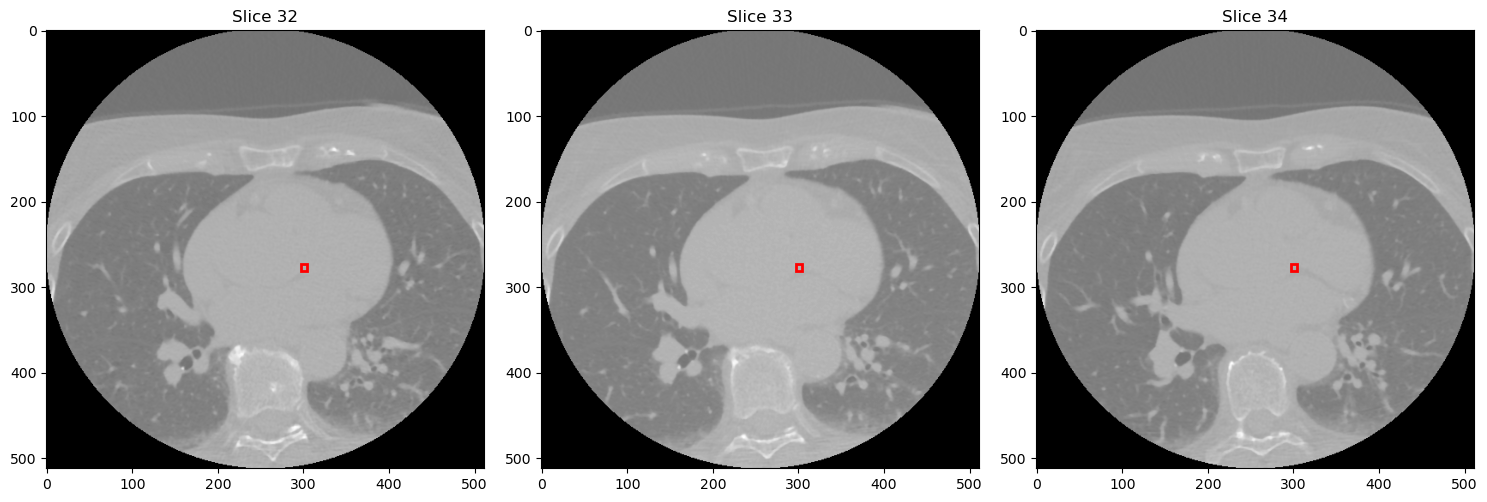

In [24]:
label_path = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\3\bifurcation.json'
center_coordinates, dimension = get_3Dbox_coordinates(label_path, spacing)
plot_bbox_patches(ct_scan, center_coordinates, dimension)

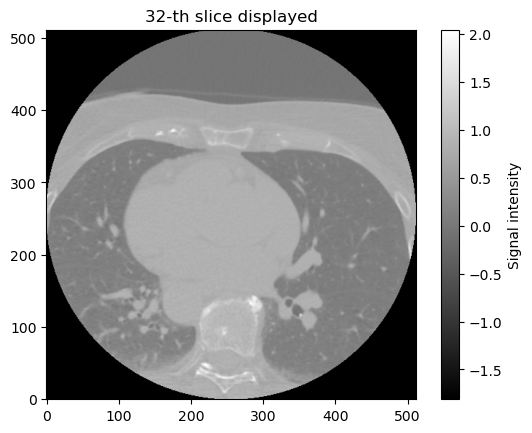

In [25]:
def normalize(ct_scan):
    scan = (ct_scan - np.mean(ct_scan)) / np.std(ct_scan)
    return scan

plot_single_slice(normalize(ct_scan))

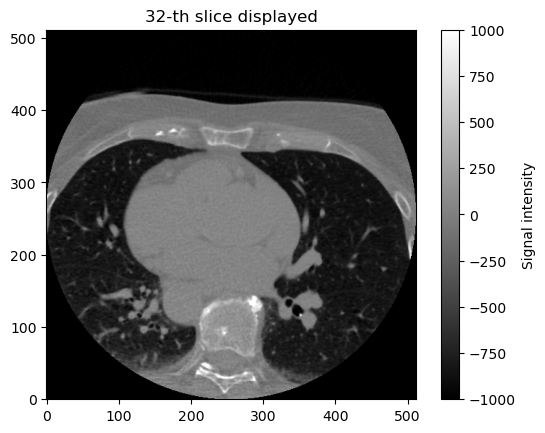

(56, 512, 512)

In [26]:
def clip_values(ct_scan, min_bound=-1000, max_bound=1000):
    """
    Clips outliers, if not specified min_bound=-1000 max_bound=1000
    """
    img = ct_scan
    img = np.clip(img, min_bound, max_bound).astype(np.float32)
    return img

clipped_scan = clip_values(ct_scan)
plot_single_slice(clipped_scan)
clipped_scan.shape

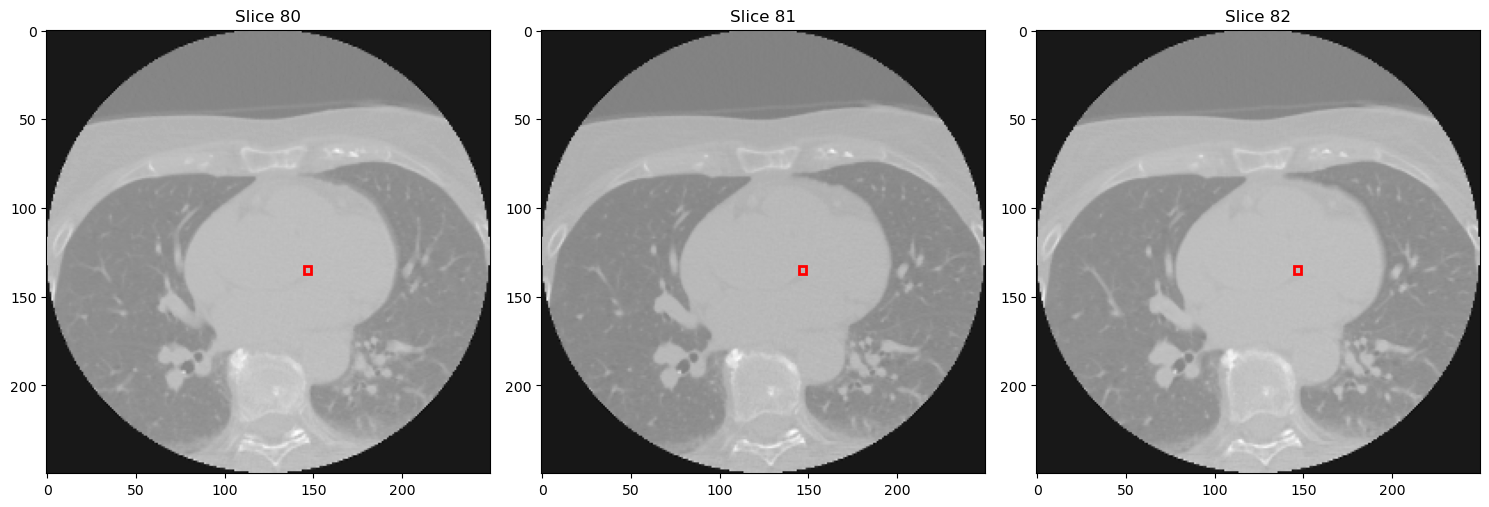

Resampled bounding box coordinates:  [146.74349975585938, 135.17697143554688, 99.39756774902344]
Resampled bounding box dimensions:  [18.64875334  3.5870903   4.41794767]
Resampled scan shape:  (140, 250, 250)


In [39]:
def resample(ct_scan, spacing, out_spacing=[1.0,1.0,1.0], label_path=None):
    """ Resample images to 1mm spacing, if otherwise specify out_spacing value """
    resize_factor = spacing / out_spacing
    new_shape = ct_scan.shape * resize_factor
    real_resize_factor = new_shape / ct_scan.shape
    new_spacing = spacing / real_resize_factor
    resampled_scan = scipy.ndimage.zoom(ct_scan, real_resize_factor, mode='nearest')
    if label_path is not None:
        resampled_coordinates, resampled_dim = get_3Dbox_coordinates(label_path, new_spacing, scaling_factor=real_resize_factor)
        return resampled_scan, resampled_coordinates, resampled_dim
    return resampled_scan

resampled_scan, resampled_coordinates, resampled_dim = resample(ct_scan, spacing, label_path=label_path)
plot_bbox_patches(resampled_scan, resampled_coordinates, resampled_dim)
print("Resampled bounding box coordinates: ", resampled_coordinates)
print("Resampled bounding box dimensions: ", resampled_dim)
print("Resampled scan shape: ", resampled_scan.shape)
#plot_single_slice(resampled_scan)


In [128]:
#Probably a bad idea to use rotate augmentation for detection boxes
#def random_rotate3D(ct_scan, min_angle, max_angle, label_path=None):
#    """
#   Returns a random rotated array in the same shape
#   should be min_angle > -360 and max_angle < 360
#   """
#    all_axes = [(1, 0), (1, 2), (0, 2)]
#    angle = np.random.randint(low=min_angle, high=max_angle+1)
#    axes_random_id = np.random.randint(low=0, high=len(all_axes))
#    axes = all_axes[axes_random_id]
#    if label_path is not None:
#        return
#    return scipy.ndimage.rotate(ct_scan, angle, axes=axes)

#rotated_scan = random_rotate3D(ct_scan, min_angle=-180, max_angle=180)
#coordinates, dim = get_3Dbox_coordinates(label_path, spacing)
#plot_bbox_patches(rotated_scan, coordinates, dim)
#print(rotated_scan.shape)
#plot_single_slice(rotated_scan)

1


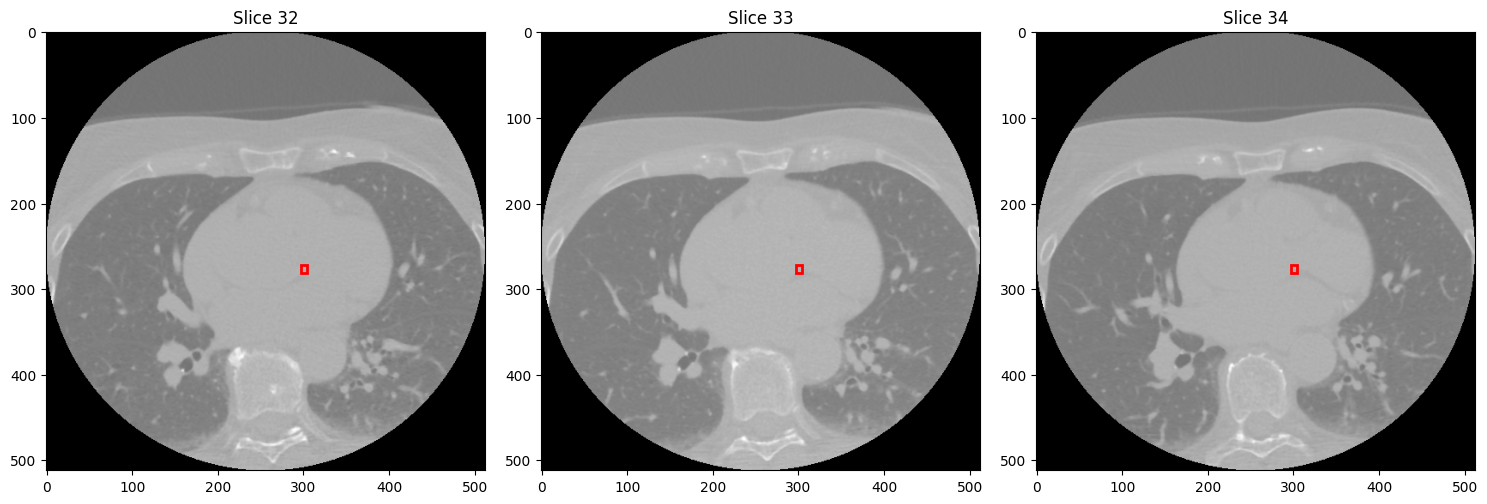

[[[300.53083424]]

 [[276.84257268]]

 [[ 39.7590271 ]]]


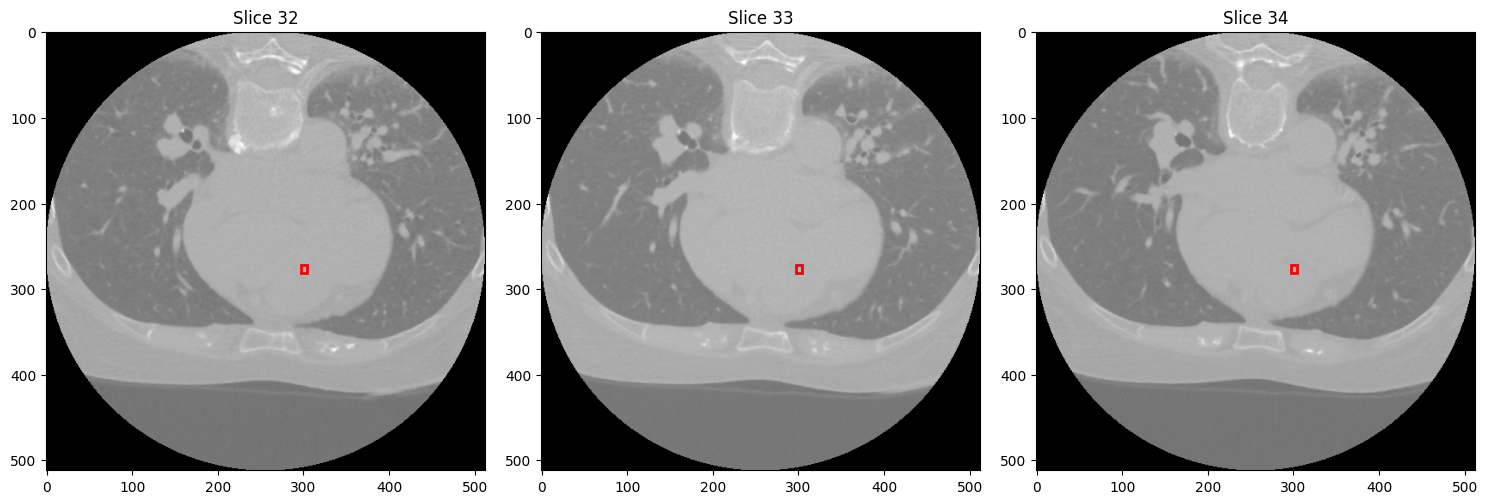

In [179]:
def random_flip(ct_scan, label_path=None, spacing=None):
    """Returns a random flipped 3d array"""
    axes = [0, 1, 2]
    rand = np.random.randint(0, 3)
    print(rand)
    img = np.flip(ct_scan, axis=axes[rand])
    img = np.squeeze(img)
    
    if label_path is not None:
        center, [l,w,h] = get_3Dbox_coordinates(label_path, spacing)
        return img, np.flip(np.array(center).reshape(3,1,-1), axis=axes[rand])
    return img

flipped_scan, flipped_center = random_flip(ct_scan, label_path=label_path, spacing=spacing)
plot_bbox_patches(ct_scan, center_coordinates, dimension)
print(flipped_center)
plot_bbox_patches(flipped_scan, flipped_center.reshape(3,), dimension)

In [139]:
def preprocess_scan(ct_scan_path, bbox=False, mask=False, label_path=None, resample=True, 
                    normalize=False, clip_values=False, random_flip=False, random_rotate3D=False):
    """Preprocess the given ct scan and label path"""
    
    
    

In [125]:

# Create a sample 3D array
array_3d = np.array([[[1, 2, 3],
                      [4, 5, 6]],
                     
                     [[7, 8, 9],
                      [10, 11, 12]]])

# Flip the 3D array along different axes
flipped_along_x = np.flip(array_3d, axis=0)
flipped_along_y = np.flip(array_3d, axis=1)
flipped_along_z = np.flip(array_3d, axis=2)

print("Original Array:")
print(array_3d)

print("\nFlipped along X-axis:")
print(flipped_along_x)

print("\nFlipped along Y-axis:")
print(flipped_along_y)

print("\nFlipped along Z-axis:")
print(flipped_along_z)


Original Array:
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]

Flipped along X-axis:
[[[ 7  8  9]
  [10 11 12]]

 [[ 1  2  3]
  [ 4  5  6]]]

Flipped along Y-axis:
[[[ 4  5  6]
  [ 1  2  3]]

 [[10 11 12]
  [ 7  8  9]]]

Flipped along Z-axis:
[[[ 3  2  1]
  [ 6  5  4]]

 [[ 9  8  7]
  [12 11 10]]]


In [144]:
import numpy as np

# Given information
original_orientation = np.array([[-1, -0, -0],
                                 [-0, -1, -0],
                                 [0, 0, 1]])

# Determine the flipping axis
flipping_axis = 0  # X-axis

# Flip the center coordinates
flipped_center = center_coordinates * np.array([-1, 1, 1])

# If needed, adjust dimensions based on the flipped orientation
adjusted_dimensions = dimension * np.abs(np.diagonal(original_orientation))

print("Original Center:", center)
print("Flipped Center:", flipped_center)
print("Adjusted Dimensions:", adjusted_dimensions)


Original Center: [146.74349975585938, 135.17697143554688, 99.39756774902344]
Flipped Center: [-300.53083424  276.84257268   39.7590271 ]
Adjusted Dimensions: [7.45950134 7.34636451 9.04796126]
